<a href="https://colab.research.google.com/github/Jakhongir0103/ML-DL_basic_projects/blob/main/House%20price%20prediction/House_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This model predicts the price of the houses in Uzbekistan, Tashkent

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/anvarnarz/praktikum_datasets/main/housing_data_08-02-2021.csv')
df.head()

,location,district,rooms,size,level,max_levels,price
0,"город Ташкент, Юнусабадский район, Юнусабад 8-...",Юнусабадский,3,57,4,4,52000
1,"город Ташкент, Яккасарайский район, 1-й тупик ...",Яккасарайский,2,52,4,5,56000
2,"город Ташкент, Чиланзарский район, Чиланзар 2-...",Чиланзарский,2,42,4,4,37000
3,"город Ташкент, Чиланзарский район, Чиланзар 9-...",Чиланзарский,3,65,1,4,49500
4,"город Ташкент, Чиланзарский район, площадь Актепа",Чиланзарский,3,70,3,5,55000


### Some info about the columns info
- `location` - locations in Tashkent, given in Russian
- `district` - districts in Tashkent, given in Russian
- `size` - size in sq.m
- `level` - the level in which the house is located
- `max_levels` - maximum levels number in the whole building
- `price` - price in usd

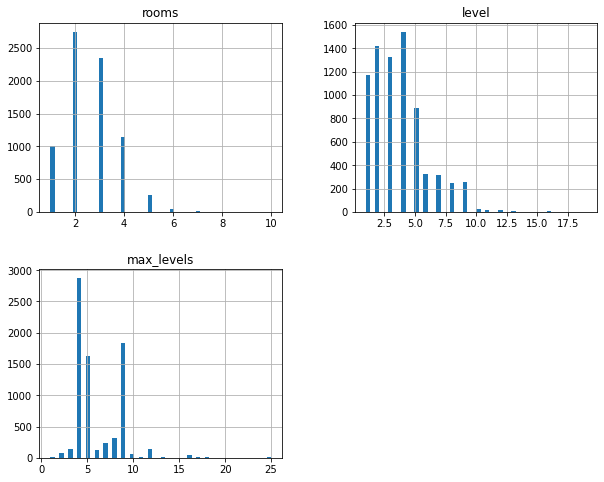

In [ ]:
df.hist(bins=50, figsize=(10,8))
plt.show()

#Train and Test sets

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

# Data filtering with sklearn

In [ ]:
### create a new coloumn
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        X['remaining_levels'] = X['max_levels'] - X['level']
        return X

In [ ]:
### filter price column

class FilterPrice(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        if X['price'].dtype != int:
          if sum(X['price'] == 'Договорная') > 0:
            X.drop(index=X[X['price'] == 'Договорная'].index, inplace=True)
          X['price'] = pd.to_numeric(X['price'])
        if sum(X['price'] > 800000) > 0: #we remove the rows with the price over 800000; as there are few of them and they may affect the accuracy of our model
          X.drop(index=X[X['price'] > 800000].index, inplace=True)
        return X

In [ ]:
### filter size column

class FilterSize(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
      if X['size'].dtype != int:
        if sum(X['size'] == 'Площадьземли:1сот') > 0:
          X['size'] = X['size'].replace(to_replace='Площадьземли:1сот', value='100')
        X['size'] = pd.to_numeric(X['size'])
      if sum(X['size'] > 7000) > 0: #we remove the rows with the size over 7000; as there are few of them and they may affect the accuracy of our modle
        X.drop(index=X[X['size'] > 7000].index, inplace=True)
      return X

#Pipeline 

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
#whole data

general_pipeline = Pipeline([
          ('price_filter', FilterPrice()),
          ('size_filter', FilterSize()),
          ('attribs_adder', CombinedAttributesAdder())          
])

In [ ]:
#numeric data
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
          ('std_scaler', StandardScaler())             
])

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

def filterData(data):
  data = general_pipeline.fit_transform(data)

  data_cat = data[['location', 'district']] #non-numeric columns
  data_num = data[['rooms', 'size', 'level', 'max_levels', 'price', 'remaining_levels']] #numeric columns

  num_attribs = list(data_num)
  cat_attribs = list(data_cat)

  full_pipeline = ColumnTransformer([
      ('num', num_pipeline, num_attribs),
      ('cat', OrdinalEncoder(), cat_attribs)
  ])
  
  return full_pipeline.fit_transform(train_set)

In [ ]:
filtered_train_set = filterData(train_set)

In [ ]:
X_train_set = filtered_train_set[:,[1,2,3,4,5,7]]
Y_train_set = filtered_train_set[:,6]

filtered data

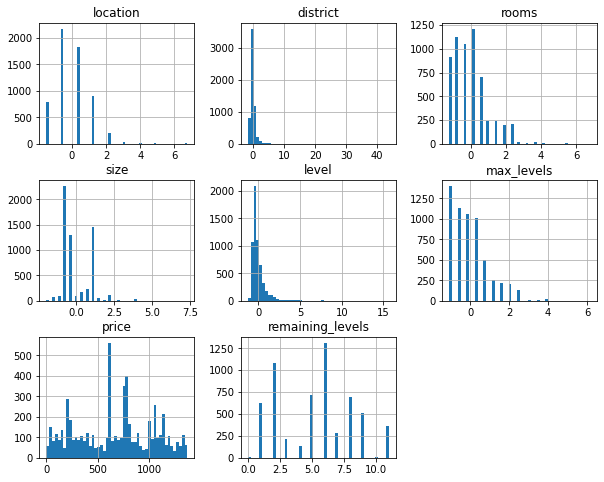

In [ ]:
new_df = pd.DataFrame(data=filtered_train_set, columns=['location', 'district', 'rooms', 'size', 'level', 'max_levels', 'price', 'remaining_levels'])
new_df.hist(bins=50, figsize=(10,8))
plt.show() 

Test sets

In [ ]:
filtered_test_set = filterData(test_set)

In [ ]:
X_test_set = filtered_test_set[:,[1,2,3,4,5,7]]
Y_test_set = filtered_test_set[:,6]

#Linear regression model

In [ ]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(X_train_set, Y_train_set)

LinearRegression()

Evaluation

In [ ]:
Y_predicted = LR_model.predict(X_test_set)

In [ ]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(Y_test_set, Y_predicted)
# RMSE 
lin_rmse = np.sqrt(lin_mse)
print("RMSE: ", lin_rmse)

RMSE:  53.55047323760638


#DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
Tree_model = DecisionTreeRegressor()
Tree_model.fit(X_train_set, Y_train_set)

DecisionTreeRegressor()

Evaluation

In [ ]:
Y_predicted_tree = Tree_model.predict(X_test_set)


In [ ]:
tree_mse = mean_squared_error(Y_test_set, Y_predicted_tree)
# RMSE 
tree_rmse = np.sqrt(tree_mse)
print("RMSE: ", tree_rmse)

RMSE:  11.000982433310742


#RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor()
RF_model.fit(X_train_set, Y_train_set)

RandomForestRegressor()

Evaluation

In [ ]:
Y_predicted_rf = RF_model.predict(X_test_set)
rf_mse = mean_squared_error(Y_test_set, Y_predicted_rf)
# RMSE hisoblaymiz
rf_rmse = np.sqrt(rf_mse)
print("RMSE: ", rf_rmse)

RMSE:  18.354350408787052


Above we trained 3 models and got the following accuracies:
- LinearRegression -> RMSE = 53.55 USD
- DecisionTree -> RMSE = 11.0 USD
- RandomForest -> RMSE = 18.35 USD

**As we can see we got the best model using the DecisionTree algorithm with 11.0 USD of Root Mean Square Error**

In [ ]:
import joblib

filename = 'Tree_model.jbl'
joblib.dump(RF_model, filename) # save the model

['Tree_model.jbl']